## Set Up

### Imports

In [1]:
import pprint
from warnings import simplefilter

import pandas as pd
from IPython.display import Markdown, display
from statsmodels.stats.multitest import multipletests

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import json
import re
import textwrap
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import helpers
import matplotlib.pyplot as plt
import numpy as np
import pyperclip
import statsmodels.api as sm
from IPython.display import clear_output
from matplotlib import colormaps
from scipy import stats
from statsmodels.genmod.families import Poisson

# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm

from mri_data import file_manager as fm

In [2]:
# reload_recursive(helpers)

### Load Data

#### Clinical and Volumes

In [3]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes2.csv",
    index_col="subid",
)
third_ventricle_width = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/third_ventricle_width.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df["allCSF"] = csf_volumes["all"]
df["thirdV"] = csf_volumes["third_ventricle"]
#! need to fix the actual segmentation files
df["periCSF"] = csf_volumes["peripheral"] - df["thirdV"]

df["thirdV_width"] = third_ventricle_width["third_ventricle_width"]
df["periCSF_frac"] = csf_volumes["peripheral"] / csf_volumes["all"]
df.rename(columns={"ventricle_volume": "LV", "choroid_volume": "CP"}, inplace=True)

df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["LV_logtrans"] = np.log(df["LV"])

# these corrections should ultimately be made to the csf file
for struct in ["brain", "white", "grey", "thalamus", "t2lv"]:
    df[struct] = df[struct] * 1000

df["CCF"] = df["LV"] / df["allCSF"]
df["peri_ratio"] = df["periCSF"] / df["LV"]


df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

MS_patients = df["dz_type2"] == "MS"
nonMS_patients = df["dz_type2"] == "!MS"
NIND_patients = df["dz_type5"] == "NIND"
OIND_patients = df["dz_type5"] == "OIND"
RMS_patients = df["dz_type5"] == "RMS"
PMS_patients = df["dz_type5"] == "PMS"

#### HIPS-THOMAS Volumes and Distances

In [4]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")

### Functions

In [5]:
def normalize_by_tiv(df, variables=None):
    if variables is None:
        variables = [
            "brain",
            "white",
            "grey",
            "csf_all",
            "csf_peripheral",
            "ventricle_volume",
            "choroid_volume",
        ]

    for var in variables:
        new_var = f"n-{var}"
        df[new_var] = df[var] / df["tiv"]

    return df


def zscore(df):
    df_z = df.copy()
    numeric_cols = df.select_dtypes(include="number").columns
    df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")
    return df_z


import os
import subprocess


def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = "run_williams_hotelling.R"

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def residualize_structs(model_data, dependent_var, independent_vars):
    """
    Residualize a dependent variable by regressing out independent variables.

    Parameters:
    -----------
    model_data : pd.DataFrame
        DataFrame containing the data
    dependent_var : str
        The dependent variable to residualize
    independent_vars : list of str
        List of independent variables to regress out

    Returns:
    --------
    np.ndarray
        Residuals of the dependent variable after regression
    """
    formula = f"{dependent_var} ~ " + " + ".join(independent_vars)
    model = sm.OLS.from_formula(formula, data=model_data).fit()
    return model.resid


# keep the following code for my reference
def run_R_script_old(p1, p2, p12, nobs):
    model_data = df.join([df_thomas2])

    disease_group = "MS"
    model_data = model_data[model_data["dz_type3"] == disease_group]

    models = {}
    models["medial"] = sm.OLS.from_formula(
        "medial ~ periCSF + age + Female + tiv", data=model_data
    ).fit()
    models["posterior"] = sm.OLS.from_formula(
        "posterior ~ periCSF + age + Female + tiv", data=model_data
    ).fit()
    models["anterior"] = sm.OLS.from_formula(
        "anterior ~ periCSF + age + Female + tiv", data=model_data
    ).fit()
    models["ventral"] = sm.OLS.from_formula(
        "ventral ~ periCSF + age + Female + tiv", data=model_data
    ).fit()
    models["THALAMUS_1"] = sm.OLS.from_formula(
        "THALAMUS_1 ~ periCSF + age + Female + tiv", data=model_data
    ).fit()
    models["LV"] = sm.OLS.from_formula(
        "LV ~ periCSF + age + Female + tiv", data=model_data
    ).fit()

    nobs = models["LV"].nobs

    structs = ["posterior", "medial", "anterior", "ventral"]
    working_structs = structs.copy()

    R_cmd = "# Regressing LV residuals controlling for peripheral CSF volume\n\nresult_text <- ''\n"
    pearson_results = {}
    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            p1, pval1 = stats.pearsonr(models[struct1].resid, models["LV"].resid)
            pearson_results[struct1] = (p1, pval1)
            p2, pval2 = stats.pearsonr(models[struct2].resid, models["LV"].resid)
            pearson_results[struct2] = (p2, pval2)
            p12, pval12 = stats.pearsonr(models[struct1].resid, models[struct2].resid)

            if abs(p1) > abs(p2):
                sign = ">"
            else:
                sign = "<"
            R_cmd += textwrap.dedent(f"""
            comparison <- '{struct1} {sign} {struct2}'
            p <- test2r.t2({p1:0.3}, {p2:0.3}, {p12:0.3}, {nobs})$p_value
            result_text <- paste(result_text, sprintf("%s, p=%.2e", comparison, p), sep='\\n')
            """)

    R_cmd += "\ncat(result_text)\n"

    pearson_results["THALAMUS_1"] = stats.pearsonr(
        models["THALAMUS_1"].resid, models["LV"].resid
    )

    # Medial has a stronger association than THALAMUS_1, so just test this one
    p1 = pearson_results["THALAMUS_1"][0]
    p2 = pearson_results["medial"][0]
    p12 = stats.pearsonr(models["medial"].resid, models["THALAMUS_1"].resid).statistic
    comparison = "'medial > THALAMUS_1'"
    R_cmd += (
        f"comparison <- {comparison}\n"
        f"p <- test2r.t2({p1:0.3}, {p2:0.3}, {p12:0.3}, {nobs})$p_value\n"
        f'result_text <- sprintf("%s, p=%.2e", comparison, p)'
    )

    pyperclip.copy(R_cmd)

    print(f"Disease group: {disease_group}")
    for struct in ["THALAMUS_1"] + structs:
        print(
            f"struct: {struct}, r: {pearson_results[struct][0]:0.3}, pval: {pearson_results[struct][1]:0.3}"
        )


from statsmodels.stats.multitest import multipletests


def run_regressions_refactored(
    model_data: pd.DataFrame,
    structs,
    predictors,
    covariates: str = "",
    robust_cov: str = "HC0",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
    """
    Run OLS for every (struct, predictor).
    Returns (results_by_struct, results_by_predictor)
    - results_by_struct: dict struct -> DataFrame indexed by predictor
    - results_by_predictor: dict predictor -> DataFrame indexed by struct
    Each DataFrame columns: coef, pval, se, llci, ulci, ci, R2, p_fdr, coef_sig
    """
    structs = list(structs)
    predictors = list(predictors)
    plus = f"+ {covariates}" if covariates else ""
    # container: per-struct dataframes
    results_by_struct = {}

    def _get_val_by_name(obj, name, attr):
        import numpy as np

        vals = getattr(obj, attr)
        # pandas Series (has .get)
        if hasattr(vals, "get"):
            return vals.get(name, np.nan)
        # numpy array / list-like: map via model exog names
        try:
            exog_names = list(obj.model.exog_names)
        except Exception:
            exog_names = []
        if name in exog_names:
            idx = exog_names.index(name)
            try:
                return np.asarray(vals)[idx]
            except Exception:
                return np.nan
        return np.nan

    for struct in structs:
        rows = []
        for pred in predictors:
            formula = f"{struct} ~ {pred} {plus}"
            try:
                res = sm.OLS.from_formula(formula, data=model_data).fit()
                if robust_cov:
                    rres = res.get_robustcov_results(cov_type=robust_cov)
                else:
                    rres = res
            except:
                pass

    # build results_by_predictor for compatibility
    results_by_predictor = {}
    cols = next(iter(results_by_struct.values())).columns
    for pred in predictors:
        rows = []
        for struct in structs:
            row = results_by_struct[struct].loc[pred].to_dict()
            row["struct"] = struct
            rows.append(row)
        df_pred = pd.DataFrame(rows).set_index("struct")[cols]
        results_by_predictor[pred] = df_pred

    return results_by_struct, results_by_predictor


# ? comma at the end: does it do anything at all?
def run_regressions(
    model_data: pd.DataFrame,
    outcome: str,
    predictors: list[str],
    covariates: list[str] = None,
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
    if covariates is None:
        covariates = []
        
    def _get_val_by_name(obj, name, attr):
        import numpy as np

        vals = getattr(obj, attr)
        # pandas Series (has .get)
        if hasattr(vals, "get"):
            return vals.get(name, np.nan)
        # numpy array / list-like: map via model exog names
        try:
            exog_names = list(obj.model.exog_names)
        except Exception:
            exog_names = []
        if name in exog_names:
            idx = exog_names.index(name)
            try:
                return np.asarray(vals)[idx]
            except Exception:
                return np.nan
        return np.nan

    results = {}
    models = {}
    for predictor in predictors:
        independent_vars = [predictor] + covariates
        formula = f"{outcome} ~ {" + ".join(independent_vars)}"
        model = sm.OLS.from_formula(formula, model_data).fit()

        if robust_cov:
            rres = model.get_robustcov_results(cov_type=robust_cov)
        else:
            rres = model
        
        # confidence interval: conf_int() returns DataFrame when names available
        ci_df = rres.conf_int()
        if hasattr(ci_df, "loc") and predictor in ci_df.index:
            llci, ulci = float(ci_df.loc[predictor, 0]), float(ci_df.loc[predictor, 1])
        else:
            # fallback via exog_names -> index
            try:
                exog_names = list(rres.model.exog_names)
                idx = exog_names.index(predictor)
                ci_arr = np.asarray(ci_df)
                llci, ulci = float(ci_arr[idx, 0]), float(ci_arr[idx, 1])
            except Exception:
                llci = ulci = np.nan

        ci_str = f"[{llci:.3}, {ulci:.3}]" if not np.isnan(llci) else ""
        results[predictor] = {
            "beta": _get_val_by_name(rres, predictor, "params"),
            "p_fdr": None,
            "se": _get_val_by_name(rres, predictor, "bse"),
            "llci": llci,
            "ulci": ulci, 
            "ci_str": ci_str,
            "p_raw": _get_val_by_name(rres, predictor, "pvalues"),
            "R2": rres.rsquared_adj,
        }
        models[predictor] = model

    results = pd.DataFrame(results).T

    fdr_method: str = "fdr_bh"
    fdr_alpha = 0.05
    _, p_fdr_vals, _, _ = multipletests(
        results["p_raw"], alpha=fdr_alpha, method=fdr_method
    )
    results["p_fdr"] = p_fdr_vals

    return results

## Analysis

### Exploratory Stuff

In [7]:
model_data = df_z[nonMS_patients].join([df_thomas2_z, df_thomas_z[df_thomas_z.columns[~df_thomas_z.columns.isin(["THALAMUS_1"])]]])

all_predictors = [
    "LV_logtrans",
    "LV",
    "CP",
    "periCSF",
    "allCSF",
    "thirdV",
    "thirdV_width",
    "THALAMUS_1",
    "medial",
    "posterior",
    "ventral",
    "anterior",
    "t2lv_logtrans",
    "brain",
    "white",
    "grey",
    "PRL"
]

In [16]:
outcome = "CCF" # LV / allCSF
covariates = ["age", "Female", "tiv", "THALAMUS_1"]

predictors = set(all_predictors).difference(set([outcome] + covariates))

results = run_regressions(model_data, outcome, predictors, covariates)

display(Markdown(f"`{outcome} ~ predictor + {" + ".join(covariates)}`"))
# display_order = results["beta"].apply(np.abs).sort_values(ascending=False).index
display_order = results.index
display_cols = results.columns[~results.columns.isin(["ci"])]
display(results.loc[display_order, display_cols])

`CCF ~ predictor + age + Female + tiv + THALAMUS_1`

,beta,p_fdr,se,llci,ulci,ci_str,p_raw,R2
posterior,-0.618795,0.096311,0.294456,-1.204155,-0.033435,"[-1.2, -0.0334]",0.038524,0.473478
thirdV,0.369598,0.008482,0.120222,0.130604,0.608591,"[0.131, 0.609]",0.002827,0.545471
grey,-0.036884,0.914461,0.076778,-0.189514,0.115746,"[-0.19, 0.116]",0.632167,0.433848
t2lv_logtrans,0.001509,0.988378,0.103282,-0.203809,0.206826,"[-0.204, 0.207]",0.988378,0.432414
anterior,-0.02944,0.914461,0.105971,-0.240104,0.181225,"[-0.24, 0.181]",0.781828,0.433132
thirdV_width,0.378473,0.000217,0.08567,0.208167,0.548779,"[0.208, 0.549]",0.000029,0.581728
medial,-0.255308,0.326468,0.195863,-0.64467,0.134054,"[-0.645, 0.134]",0.195881,0.440516
periCSF,-0.232041,0.113963,0.122125,-0.474817,0.010735,"[-0.475, 0.0107]",0.06078,0.460155
allCSF,0.290008,0.113691,0.14785,-0.003908,0.583925,"[-0.00391, 0.584]",0.053056,0.465804
LV_logtrans,0.83431,0.0,0.052536,0.729872,0.938748,"[0.73, 0.939]",0.0,0.915316


In [13]:
outcome = "CP"
covariates = ["age", "Female", "tiv", "THALAMUS_1"]

predictors = set(all_predictors).difference(set([outcome] + covariates))
# predictors = ["medial", "ventral", "posterior", "anterior"]

results = run_regressions(model_data, outcome, predictors, covariates)
results.index.name = "predictor"
display(Markdown(f"`{outcome} ~ predictor + {" + ".join(covariates)}`"))
display_order = results["beta"].apply(np.abs).sort_values(ascending=False).index
display_cols = results.columns[~results.columns.isin(["ci"])]
display(results.loc[display_order, display_cols])

`CP ~ predictor + age + Female + tiv + THALAMUS_1`

,beta,p_fdr,se,llci,ulci,ci_str,p_raw,R2
predictor,,,,,,,,
posterior,-0.909735,0.01549,0.313209,-1.532478,-0.286992,"[-1.53, -0.287]",0.004686,0.445238
ventral,0.827444,0.000174,0.184718,0.460176,1.194712,"[0.46, 1.19]",0.000023,0.500986
PRL,-0.646028,0.561335,0.849492,-2.335046,1.042991,"[-2.34, 1.04]",0.449068,0.387765
LV_logtrans,0.643419,0.0,0.090003,0.464469,0.822369,"[0.464, 0.822]",0.0,0.5864
medial,-0.601186,0.129127,0.336392,-1.270024,0.067651,"[-1.27, 0.0677]",0.077476,0.41385
LV,0.454795,0.019544,0.170423,0.115947,0.793642,"[0.116, 0.794]",0.009121,0.462434
thirdV,0.440836,0.001193,0.114889,0.212405,0.669267,"[0.212, 0.669]",0.000239,0.493808
allCSF,0.368016,0.019544,0.135796,0.098017,0.638016,"[0.098, 0.638]",0.008136,0.419851
thirdV_width,0.282958,0.01549,0.098557,0.087,0.478916,"[0.087, 0.479]",0.005163,0.440127


Text(0.5, 0, 'LV_logtrans')

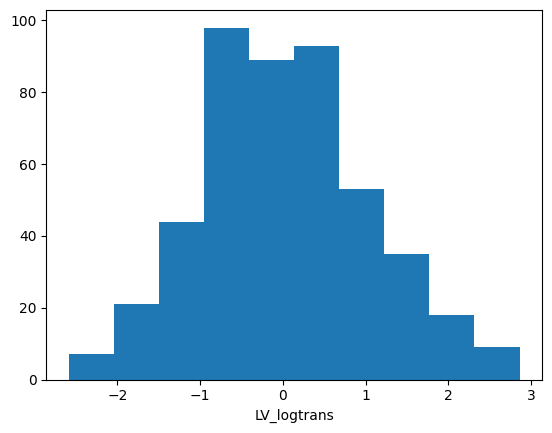

In [71]:
var = "LV_logtrans"
plt.hist(model_data[var])
plt.xlabel(var)

In [49]:
outcome = "PRL"
covariates = ["age", "Female", "tiv", "THALAMUS_1"]

predictors = all_predictors.difference(set([outcome] + covariates))
# predictors = hips_thomas_ref.iloc[1:].values.tolist() + list(predictors)
predictors = hips_thomas_ref[thalamic_nuclei].values.tolist()

results = run_regressions(model_data, outcome, predictors, covariates)

display(Markdown(f"`{outcome} ~ predictor + {" + ".join(covariates)}`"))
# display_order = results["beta"].apply(np.abs).sort_values(ascending=False).index
display_cols = results.columns[~results.columns.isin(["ci"])]
display(results.loc[:, display_cols])

`PRL ~ predictor + age + Female + tiv + THALAMUS_1`

,beta,p_fdr,se,llci,ulci,ci_str,p_raw,R2
AV_2,-0.130687,0.211461,0.064179,-0.256807,-0.004567,"[-0.257, -0.00457]",0.042292,0.177521
VA_4,0.114922,0.713488,0.101249,-0.084044,0.313888,"[-0.084, 0.314]",0.256947,0.17551
VLa_5,0.019357,0.768922,0.065849,-0.110044,0.148758,"[-0.11, 0.149]",0.768922,0.171597
VLP_6,0.109347,0.713488,0.102239,-0.091565,0.310258,"[-0.0916, 0.31]",0.285395,0.17345
VPL_7,0.032954,0.768922,0.099668,-0.162905,0.228813,"[-0.163, 0.229]",0.741069,0.171701
Pul_8,-0.529293,0.01797,0.168558,-0.860528,-0.198058,"[-0.861, -0.198]",0.001797,0.197286
LGN_9,-0.041452,0.768922,0.067016,-0.173146,0.090243,"[-0.173, 0.0902]",0.536529,0.17212
MGN_10,-0.029754,0.768922,0.075233,-0.177596,0.118088,"[-0.178, 0.118]",0.692669,0.171692
CM_11,0.035588,0.768922,0.064239,-0.090649,0.161826,"[-0.0906, 0.162]",0.579849,0.171878
MD_Pf_12,0.049744,0.768922,0.136942,-0.219363,0.318851,"[-0.219, 0.319]",0.716585,0.171756


In [41]:
thalamic_nuclei

[2, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [40]:
formula = "t2lv_logtrans ~ VPL_7 + THALAMUS_1 + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          t2lv_logtrans   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     49.82
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           3.06e-41
Time:                        00:30:29   Log-Likelihood:                -554.00
No. Observations:                 468   AIC:                             1120.
Df Residuals:                     462   BIC:                             1145.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0563      0.037      1.522      0.1

In [38]:
formula = "VPL_7 ~ t2lv + THALAMUS_1 + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  VPL_7   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     276.4
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          2.46e-136
Time:                        00:29:48   Log-Likelihood:                -339.92
No. Observations:                 468   AIC:                             691.8
Df Residuals:                     462   BIC:                             716.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0180      0.023      0.770      0.4

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     240.8
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           4.67e-44
Time:                        12:35:45   Log-Likelihood:                -5059.2
No. Observations:                 467   AIC:                         1.012e+04
Df Residuals:                     465   BIC:                         1.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.441e+04   5044.560    -10.787      0.0

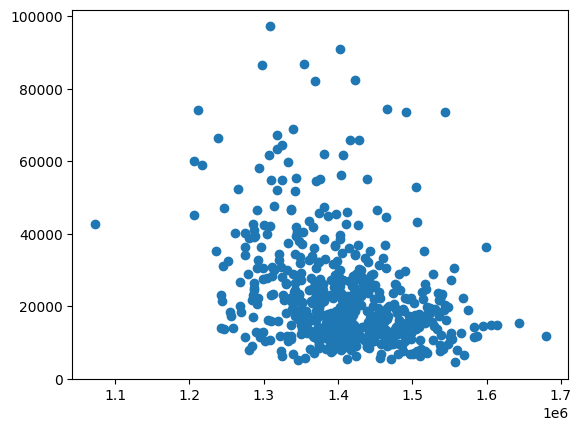

In [ ]:
work_data = df[df["dz_type2"] == "MS"]
modelA = sm.OLS.from_formula("LV ~ allCSF", data=work_data).fit()
modelB = sm.OLS.from_formula(
    "LV ~ allCSF + brain + age + Female + tiv", data=work_data
).fit()
print(modelA.summary())
print(modelB.summary())
modelB.rsquared_adj

work_data["DVE"] = modelA.resid
plt.scatter(df["brain"], df["LV"])

In [ ]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]

formula = "LV ~ THALAMUS_1 + periCSF + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     113.9
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.64e-67
Time:                        02:38:37   Log-Likelihood:                -513.11
No. Observations:                 467   AIC:                             1036.
Df Residuals:                     462   BIC:                             1057.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0183      0.034     -0.538      0.5

In [ ]:
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type2"] == "MS"]

formula = "LV ~ CP + age + Female + tiv"
# formula = "THALAMUS_1 ~ periCSF + age + Female + tiv"

result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     73.03
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           6.34e-48
Time:                        03:20:17   Log-Likelihood:                -5042.2
No. Observations:                 467   AIC:                         1.009e+04
Df Residuals:                     462   BIC:                         1.012e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.908e+04   8907.656     -5.510      0.0

LV ~ (0.10)periCSF
LV ~ (0.12)periCSF +  (-4.77)Thal
LV ~ (0.06)periCSF + (0.017)TIV
LV ~ (-0.09)periCSF + (-6.96)Thal + (0.08)TIV

In [ ]:
formula = "EDSS ~ THALAMUS_1 + age + Female + tiv"
# formula = "THALAMUS_1 ~ CP + age + Female + tiv"

result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.098
Date:                Sun, 26 Oct 2025   Prob (F-statistic):              0.370
Time:                        03:09:55   Log-Likelihood:                -86.720
No. Observations:                  46   AIC:                             183.4
Df Residuals:                      41   BIC:                             192.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7127      4.932      1.969      0.0

In [ ]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data["dz_type3"] == "MS"]

formula = "ventricle_volume ~ csf_all + choroid_volume + age + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     84.31
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           8.60e-63
Time:                        17:19:18   Log-Likelihood:                -521.71
No. Observations:                 467   AIC:                             1055.
Df Residuals:                     461   BIC:                             1080.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0222      0.035      0.

### Relative effect size

Compare influence of thalamic nuclei volumes on LV volume. I find that the

Define a model for each nucleus to regress out peripheral CSF volume, age, sex, and TIV. Do the same for LV volume. Then get Pearson r for each set of residuals to do the Williams-Hotelling test. 

The following produces R code which I copy into Rstudio.

The trend I find is not specific to MS, so what does this mean.

In [84]:
def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualize_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualize_vars[var] = residualize_structs(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )
        
    residualize_vars = pd.DataFrame(residualize_vars).dropna()

    nobs = residualize_vars[influenced_var].shape[0]

    structs = ["posterior", "medial", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualize_vars["THALAMUS_1"], residualize_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualize_vars[struct], residualize_vars[influenced_var]
        )

        thalamus_comps[f"THALAMUS_1 vs {struct}"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualize_vars["THALAMUS_1"], residualize_vars[struct])[0],
            nobs,
        )
        if thalamus_comps[f"THALAMUS_1 vs {struct}"] >= 0.05:
            sign = "="
        elif abs(pearson_results["THALAMUS_1"][0]) > abs(pearson_results[struct][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}
        

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualize_vars[struct1], residualize_vars[struct2])[0],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps

In [74]:


check1 = residualize_structs(
        model_data,
        dependent_var="LV_logtrans",
        independent_vars=covariates,
    )

check2 = residualize_structs(
        model_data,
        dependent_var="THALAMUS_1",
        independent_vars=covariates,
    )

check3 = pd.concat([check1, check2], keys=["THALAMUS_1", "LV"], axis=1).dropna()
stats.pearsonr(
        check3["THALAMUS_1"], check3["LV"],
    )

PearsonRResult(statistic=np.float64(-0.6162837190336059), pvalue=np.float64(3.4626858651227446e-50))

In [77]:
influenced_var = "LV"
residualize_vars = {}
for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
    residualize_vars[var] = residualize_structs(
        model_data,
        dependent_var=var,
        independent_vars=covariates,
    )
    
check3 = pd.DataFrame(residualize_vars)
check3['LV'].shape

(468,)

In [85]:
results = {}

# MS group
disease_group = "MS"
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type3"] == disease_group]

covariates = ["age", "Female", "tiv"]
influenced_var = "LV_logtrans"

model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type3"] == disease_group]

results[disease_group] = thalamus_influence_analysis(
    model_data, influenced_var, covariates
)

pearson_results, thalamus_comps, nuclei_comps = results[disease_group]

print(f"Patients with {disease_group}")
print("Pearson correlations of residualized thalamic nuclei and LV:")
for struct in pearson_results:
    print(
        f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
    )

print("\nComparisons between thalamic nuclei and whole thalamus:")
for comp in thalamus_comps:
    print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

print("\nComparisons between thalamic nuclei:")
for comp in nuclei_comps:
    print(f"{comp}: p={nuclei_comps[comp]:0.2e}")

Patients with MS
Pearson correlations of residualized thalamic nuclei and LV:
THALAMUS_1: r=-0.616, p=3.46e-50
posterior: r=-0.61, p=6.16e-49
medial: r=-0.665, p=6.05e-61
anterior: r=-0.373, p=7.69e-17
ventral: r=-0.412, p=1.45e-20

Comparisons between thalamic nuclei and whole thalamus:
THALAMUS_1 = posterior: p=6.24e-01
THALAMUS_1 < medial: p=3.46e-04
THALAMUS_1 > anterior: p=4.96e-15
THALAMUS_1 > ventral: p=4.44e-31

Comparisons between thalamic nuclei:
posterior < medial: p=2.52e-03
posterior > anterior: p=5.32e-13
posterior > ventral: p=2.13e-12
medial > anterior: p=4.49e-19
medial > ventral: p=1.14e-22
anterior = ventral: p=2.89e-01


In [43]:
residualize_vars = {}
for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
    influenced_var
]:
    residualize_vars[var] = residualize_structs(
        model_data,
        dependent_var=var,
        independent_vars=covariates,
    )

nobs = residualize_vars[influenced_var].shape[0]

structs = ["posterior", "medial", "anterior", "ventral"]
working_structs = structs.copy()

nuclei_comps = {}
thalamus_comps = {}
pearson_results = {}
pearson_results["THALAMUS_1"] = stats.pearsonr(
    residualize_vars["THALAMUS_1"], residualize_vars[influenced_var]
)
for i, struct in enumerate(structs):
    pearson_results[struct] = stats.pearsonr(
        residualize_vars[struct], residualize_vars[influenced_var]
    )

    thalamus_comps[f"THALAMUS_1 vs {struct}"] = run_R_script(
        pearson_results["THALAMUS_1"][0],
        pearson_results[struct][0],
        stats.pearsonr(residualize_vars["THALAMUS_1"], residualize_vars[struct])[0],
        nobs,
    )
    if thalamus_comps[f"THALAMUS_1 vs {struct}"] >= 0.05:
        sign = "="
    elif abs(pearson_results["THALAMUS_1"][0]) > abs(pearson_results[struct][0]):
        sign = ">"
    else:
        sign = "<"
    thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}
    

for i, struct1 in enumerate(structs):
    working_structs = working_structs[1:]
    for struct2 in working_structs:
        
        nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
            pearson_results[struct1][0],
            pearson_results[struct2][0],
            stats.pearsonr(residualize_vars[struct1], residualize_vars[struct2])[0],
            nobs,
        )
        if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
            sign = ">"
        else:
            sign = "<"
        nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}


ValueError: `x` and `y` must be broadcastable.

In [15]:
covariates = ["periCSF", "age", "Female", "tiv"]
influenced_var = "LV_logtrans"
results = {}

# MS group
disease_group = "MS"
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type3"] == disease_group]

results[disease_group] = thalamus_influence_analysis(
    model_data, influenced_var, covariates
)

pearson_results, thalamus_comps, nuclei_comps = results[disease_group]

print(f"Patients with {disease_group}")
print("Pearson correlations of residualized thalamic nuclei and LV:")
for struct in pearson_results:
    print(
        f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
    )

print("\nComparisons between thalamic nuclei and whole thalamus:")
for comp in thalamus_comps:
    print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

print("\nComparisons between thalamic nuclei:")
for comp in nuclei_comps:
    print(f"{comp}: p={nuclei_comps[comp]:0.2e}")

# NIND group
disease_group = "NIND"
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type3"] == disease_group]

results[disease_group] = thalamus_influence_analysis(
    model_data, influenced_var, covariates
)

pearson_results, thalamus_comps, nuclei_comps = results[disease_group]

print(f"Patients with {disease_group}")
print("Pearson correlations of residualized thalamic nuclei and LV:")
for struct in pearson_results:
    print(
        f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
    )

print("\nComparisons between thalamic nuclei and whole thalamus:")
for comp in thalamus_comps:
    print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

print("\nComparisons between thalamic nuclei:")
for comp in nuclei_comps:
    print(f"{comp}: p={nuclei_comps[comp]:0.2e}")


# OIND group
disease_group = "OIND"
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type3"] == disease_group]

results[disease_group] = thalamus_influence_analysis(
    model_data, influenced_var, covariates
)

pearson_results, thalamus_comps, nuclei_comps = results[disease_group]


print(f"Patients with {disease_group}")
print("Pearson correlations of residualized thalamic nuclei and LV:")
for struct in pearson_results:
    print(
        f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
    )

print("\nComparisons between thalamic nuclei and whole thalamus:")
for comp in thalamus_comps:
    print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

print("\nComparisons between thalamic nuclei:")
for comp in nuclei_comps:
    print(f"{comp}: p={nuclei_comps[comp]:0.2e}")


# # RMS patients
# disease_group = "RMS"
# model_data = df.join([df_thomas2])
# model_data = model_data[model_data["dz_type5"] == disease_group]

# results[disease_group] = thalamus_influence_analysis(
#     model_data, influenced_var, covariates
# )

# pearson_results, thalamus_comps, nuclei_comps = results[disease_group]

# print(f"Patients with {disease_group}")
# print("Pearson correlations of residualized thalamic nuclei and LV:")
# for struct in pearson_results:
#     print(
#         f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
#     )

# print("\nComparisons between thalamic nuclei and whole thalamus:")
# for comp in thalamus_comps:
#     print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

# print("\nComparisons between thalamic nuclei:")
# for comp in nuclei_comps:
#     print(f"{comp}: p={nuclei_comps[comp]:0.2e}")


# # PMS patients
# disease_group = "PMS"
# model_data = df.join([df_thomas2])
# model_data = model_data[model_data["dz_type5"] == disease_group]

# results[disease_group] = thalamus_influence_analysis(
#     model_data, influenced_var, covariates
# )

# pearson_results, thalamus_comps, nuclei_comps = results[disease_group]


# print(f"Patients with {disease_group}")
# print("Pearson correlations of residualized thalamic nuclei and LV:")
# for struct in pearson_results:
#     print(
#         f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}"
#     )

# print("\nComparisons between thalamic nuclei and whole thalamus:")
# for comp in thalamus_comps:
#     print(f"{comp}: p={thalamus_comps[comp]:0.2e}")

# print("\nComparisons between thalamic nuclei:")
# for comp in nuclei_comps:
#     print(f"{comp}: p={nuclei_comps[comp]:0.2e}")

Patients with MS
Pearson correlations of residualized thalamic nuclei and LV:
THALAMUS_1: r=-0.639, p=7.09e-55
posterior: r=-0.625, p=7.14e-52
medial: r=-0.681, p=4.92e-65
anterior: r=-0.379, p=2.34e-17
ventral: r=-0.43, p=2.15e-22

Comparisons between thalamic nuclei and whole thalamus:
THALAMUS_1 > posterior: p=2.70e-01
THALAMUS_1 < medial: p=1.69e-03
THALAMUS_1 > anterior: p=7.30e-17
THALAMUS_1 > ventral: p=3.21e-31

Comparisons between thalamic nuclei:
posterior < medial: p=1.85e-03
posterior > anterior: p=1.08e-13
posterior > ventral: p=9.08e-12
medial > anterior: p=3.20e-20
medial > ventral: p=5.93e-22
anterior < ventral: p=1.74e-01
Patients with NIND
Pearson correlations of residualized thalamic nuclei and LV:
THALAMUS_1: r=-0.276, p=5.45e-02
posterior: r=-0.358, p=1.16e-02
medial: r=-0.307, p=3.17e-02
anterior: r=-0.0935, p=5.23e-01
ventral: r=0.044, p=7.64e-01

Comparisons between thalamic nuclei and whole thalamus:
THALAMUS_1 < posterior: p=1.98e-01
THALAMUS_1 < medial: p=6.7

In [ ]:
import re

# disease_groups = ["NIND", "OIND", "RMS", "PMS"]
disease_groups = ["MS", "NIND", "OIND"]
result_unpacked = {}
for disease_group in disease_groups:
    result = results[disease_group]
    result_unpacked[disease_group] = {
        tuple(re.split(r"\s*[><=]\s*", k)): sub_result[k]
        for sub_result in result[1:]
        for k in sub_result
    }
    result_unpacked[disease_group].update(
        {(k, "pearson"): v for k, v in result[0].items()}
    )

columns = pd.MultiIndex.from_tuples(
    tuple(result_unpacked[disease_groups[0]].keys()), names=("first", "second")
)
thal_influence_results = pd.DataFrame(result_unpacked).T
thal_influence_results.columns = columns

In [ ]:
def query_df(df, sub_cols):
    if isinstance(sub_cols, str):
        sub_cols = [sub_cols]
    out = pd.DataFrame()
    for col in sub_cols:
        try:
            check1 = df.xs(col, level="first", axis=1, drop_level=False)
        except KeyError:
            pass
        else:
            out = pd.concat((out, check1), axis=1)
        try:
            check2 = df.xs(col, level="second", axis=1, drop_level=False)
        except KeyError:
            pass
        else:
            out = pd.concat((out, check2), axis=1)

    return out[out.columns[~out.columns.duplicated()]]

Then to do one more check, put all in one model.

In [26]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]

model_combined = sm.OLS.from_formula(
    """LV_logtrans ~ medial + THALAMUS_1 +
       age + Female + tiv""",
    data=model_data,
).fit()

print(model_combined.summary())
model_combined.wald_test("medial = THALAMUS_1")

                            OLS Regression Results                            
Dep. Variable:            LV_logtrans   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     129.9
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.17e-85
Time:                        16:38:19   Log-Likelihood:                -463.76
No. Observations:                 467   AIC:                             939.5
Df Residuals:                     461   BIC:                             964.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0059      0.031     -0.192      0.8

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[12.29187503]]), p=0.0004994446187834667, df_denom=461, df_num=1>

In [ ]:
model_data = df_z.join([df_thomas2])
model_data = model_data[model_data["dz_type2"] == "MS"]

model_combined = sm.OLS.from_formula(
    """LV ~ medial + posterior + anterior + ventral + THALAMUS_1 +
       age + Female + tiv""",
    data=model_data,
).fit()

print(model_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     77.92
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.45e-80
Time:                        02:27:56   Log-Likelihood:                -472.75
No. Observations:                 467   AIC:                             963.5
Df Residuals:                     458   BIC:                             1001.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0611      0.262     11.697      0.0

In [ ]:
model_data = work_data.join([df_thomas2])
model_data = zscore(model_data)

model = sm.OLS.from_formula(
    "ventricle_volume ~ csf_peripheral + choroid_volume + THALAMUS_1 + age + Female + tiv",
    data=model_data,
).fit()
print(model.summary())

NameError: name 'work_data' is not defined

Ventricle volume as outcome, csf_peripheral is not significant while white is a covariate, but choroid volume is. Grey isnt important

### Mediation

In [ ]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]


model = sm.OLS.from_formula(
    "THALAMUS_1 ~ periCSF*CP + LV + age + Female + tiv",
    data=model_data,
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     107.7
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.06e-92
Time:                        02:45:17   Log-Likelihood:                -439.79
No. Observations:                 467   AIC:                             895.6
Df Residuals:                     459   BIC:                             928.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0364      0.030     -1.196      0.2

In [ ]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]

from pyprocessmacro import Process

p2 = Process(
    data=model_data,
    model=4,
    x="choroid_volume",
    y="ventricle_volume",
    m=["THALAMUS_1", "csf_all"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
)
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = ventricle_volume
    m1 = THALAMUS_1
    m2 = csf_all
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = ventricle_volume 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5614   0.5547 0.4662 98.1310    6  460   0.0000

Coefficients

                 coeff     se       t      p    LLCI    ULCI
Cons           -0.0011 0.0318 -0.0337 0.9731 -0.0634  0.0612
choroid_volume  0.1933 0.0408  4.7365 0.0000  0.1133  0.2733
age             0.1000 0.0363  2.7538 0.0061  0.0288  0.1712


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:827: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  ci = bias_corrected_ci(e[i], be[i], conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch 

In [ ]:
p2 = Process(
    data=model_data,
    model=4,
    x="choroid_volume",
    y="THALAMUS_1",
    m=["ventricle_volume"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
)
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = THALAMUS_1
    m1 = ventricle_volume
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²          MSE        F  df1  df2  p-value
 0.5776   0.5720 1154905.9165 126.0550    5  461   0.0000

Coefficients

                    coeff       se        t      p       LLCI      ULCI
Cons             225.1544 831.1034   0.2709 0.7866 -1403.7783 1854.0871
choroid_volume    -0.6511   0.1234  -5.2785 0.0000    -0.8929   -0.4094
age               -8.2519   4.5302  -

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:827: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  ci = bias_corrected_ci(e[i], be[i], conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch 